In [1]:
# Install required packages
!pip install kaggle pillow

# --- Kaggle Setup: Upload your kaggle.json automatically if not already present ---
import os
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")):
    from google.colab import files
    print("Please upload your kaggle.json file")
    files.upload()  # Upload your kaggle.json when prompted
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

# --- Download and unzip Kaggle dataset ---
# This uses the dataset: "Chest X-Ray Images (Pneumonia)" by Paul Mooney
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --unzip

# For simplicity, we will use images from the 'train/NORMAL' folder.
# If you wish, you can combine NORMAL and PNEUMONIA or choose one.

# --- Imports and Dataset Definition ---
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

# Custom Dataset: Reads images from a given folder (e.g., '/content/chest_xray/train/NORMAL')
# It creates an HR image (the original), a LR image (downsampled by a factor), and a dummy segmentation map.
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, hr_size=(256,256), downscale_factor=4):
        """
        root_dir: directory containing HR images.
        hr_size: desired HR image size.
        downscale_factor: factor by which to downsample HR to generate LR.
        """
        self.root_dir = root_dir
        self.filenames = sorted(os.listdir(root_dir))
        self.hr_size = hr_size
        self.downscale_factor = downscale_factor

        self.transform_hr = transforms.Compose([
            transforms.Resize(hr_size),
            transforms.ToTensor()
        ])
        # LR transform: we generate LR by resizing the HR tensor using bicubic interpolation

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        path = os.path.join(self.root_dir, fname)
        hr_img = Image.open(path).convert('L')  # grayscale
        hr_img = self.transform_hr(hr_img)  # Tensor of shape (1,H,W)

        # Create LR image: downsample HR by downscale_factor using bicubic interpolation.
        lr_img = F.interpolate(hr_img.unsqueeze(0), scale_factor=1/self.downscale_factor, mode='bicubic', align_corners=False).squeeze(0)

        # Create a dummy segmentation map by simple thresholding (binary segmentation)
        # For CrossEntropyLoss, seg target should be of shape (H, W) with integer class labels.
        seg_map = (lr_img > 0.5).long().squeeze(0)
        return lr_img, hr_img, seg_map

# Set dataset path to the "NORMAL" images folder from the downloaded dataset.
dataset_path = '/content/chest_xray/train/NORMAL'
dataset = ChestXrayDataset(root_dir=dataset_path, hr_size=(256,256), downscale_factor=2)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# --- Define the Generator Network (Anatomically-Guided SR) ---
class AnatoSRGenerator(nn.Module):
    def __init__(self):
        super(AnatoSRGenerator, self).__init__()
        # Input: 1 channel LR image + 1 channel segmentation map = 2 channels
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.resblock = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1)
        )
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, 3, padding=1),
            nn.PixelShuffle(2),  # upscale factor 2 (from 256x256 HR -> 512x512, adjust if needed)
            nn.ReLU(inplace=True)
        )
        self.conv_final = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, lr, seg):
        # Concatenate LR image and segmentation map along channel dimension
        x = torch.cat([lr, seg.float()], dim=1)
        x = self.relu(self.conv1(x))
        res = self.resblock(x)
        x = x + res
        x = self.upsample(x)
        hr = self.conv_final(x)
        return hr

# --- Dummy Segmentation Network ---
# In this example, we use a simple dummy segmentation network that upsamples the LR image.
# Replace this with your actual segmentation model if available.
# Updated DummySegNet: No upsampling, outputs segmentation at LR resolution.
class DummySegNet(nn.Module):
    def __init__(self):
        super(DummySegNet, self).__init__()
    def forward(self, x):
        # For demonstration: use a simple threshold on x to create a dummy segmentation map.
        seg = (x > 0.5).float()
        # Duplicate the channel to create 2 channels (for 2 classes)
        seg = torch.cat([seg, seg], dim=1)
        return seg


# Instantiate models
generator = AnatoSRGenerator().cuda()
seg_net = DummySegNet().cuda()  # Replace with your segmentation model if available

# --- Define Combined Loss Function ---
def combined_loss(hr_pred, hr_gt, seg_pred, seg_gt, lambda_seg=0.1):
    pixel_loss = nn.MSELoss()(hr_pred, hr_gt)
    # seg_pred: shape (B, C, H, W); seg_gt: shape (B, H, W)
    seg_loss = nn.CrossEntropyLoss()(seg_pred, seg_gt)
    return pixel_loss + lambda_seg * seg_loss

# --- Training Loop ---
optimizer = optim.Adam(generator.parameters(), lr=1e-4)
num_epochs = 2  # For demonstration; increase as needed

generator.train()
seg_net.eval()  # Assuming seg_net is pretrained; our dummy is fixed

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (lr_img, hr_img, seg_map) in enumerate(train_loader):
        lr_img, hr_img, seg_map = lr_img.cuda(), hr_img.cuda(), seg_map.cuda()
        # Get segmentation prediction from seg_net using the LR image
        seg_pred = seg_net(lr_img)
        # Forward pass through generator: note that lr_img and seg_pred are used
        hr_pred = generator(lr_img, seg_pred)
        loss = combined_loss(hr_pred, hr_img, seg_pred, seg_map)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {running_loss/10:.4f}")
            running_loss = 0.0

print("Training complete!")


Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.28G/2.29G [00:11<00:00, 237MB/s]
100% 2.29G/2.29G [00:11<00:00, 220MB/s]
Epoch [1/2], Batch [10/336], Loss: 0.2265
Epoch [1/2], Batch [20/336], Loss: 0.0947
Epoch [1/2], Batch [30/336], Loss: 0.0861
Epoch [1/2], Batch [40/336], Loss: 0.0805
Epoch [1/2], Batch [50/336], Loss: 0.0784
Epoch [1/2], Batch [60/336], Loss: 0.0769
Epoch [1/2], Batch [70/336], Loss: 0.0758
Epoch [1/2], Batch [80/336], Loss: 0.0746
Epoch [1/2], Batch [90/336], Loss: 0.0734
Epoch [1/2], Batch [100/336], Loss: 0.0726
Epoch [1/2], Batch [110/336], Loss: 0.0721
Epoch [1/2], Batch [120/336], Loss: 0.0718
Epoch [1/2], Batch [130/336], Loss: 0.0718
Epoch [1/2], Batch [140/336], Loss: 0.0715
Epoch [1/2], Batch [150/336], Loss: 0.0714
Epoch [1/2], Batch [160/336], Loss: 0.0714
Epoch [1/2], Batch [170/336], Loss: 0.0711
Epoch [1/2], Batch [180/336], Loss: 0.0711
Epoch [1/2], Batch 

Average PSNR: 34.01 dB, Average SSIM: 0.9172


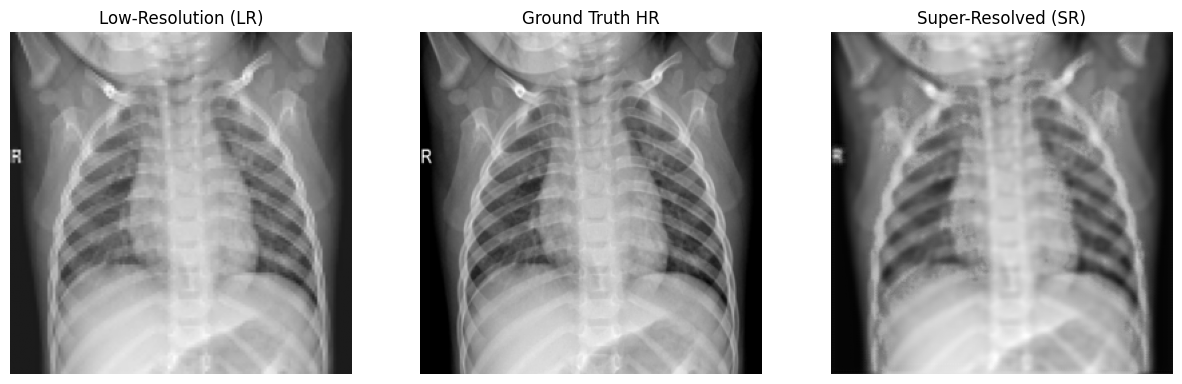

In [ ]:
# Install scikit-image if not already installed
!pip install scikit-image

import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Set the generator to evaluation mode
generator.eval()

psnr_total = 0.0
ssim_total = 0.0
count = 0

# Evaluate on a few samples from the test dataset (using the same train_loader for demonstration)
with torch.no_grad():
    for lr_img, hr_img, seg_map in train_loader:
        lr_img, hr_img, seg_map = lr_img.cuda(), hr_img.cuda(), seg_map.cuda()
        # Get segmentation prediction from seg_net (dummy in this case)
        seg_pred = seg_net(lr_img)
        # Generate super-resolved (SR) image
        sr_img = generator(lr_img, seg_pred)

        # Convert images to numpy arrays
        # Note: images are in [0,1] range as they're output of ToTensor()
        sr_np = sr_img[0].squeeze().cpu().numpy()      # shape (H, W)
        hr_np = hr_img[0].squeeze().cpu().numpy()        # shape (H, W)


        # Compute PSNR and SSIM for one image in the batch (here, the first image)
        psnr_val = peak_signal_noise_ratio(hr_np, sr_np, data_range=1)
        ssim_val = structural_similarity(hr_np, sr_np, win_size=5, data_range=1)
        psnr_total += psnr_val
        ssim_total += ssim_val
        count += 1

        # For demonstration, evaluate on 5 batches
        if count >= 5:
            break

avg_psnr = psnr_total / count
avg_ssim = ssim_total / count
print(f"Average PSNR: {avg_psnr:.2f} dB, Average SSIM: {avg_ssim:.4f}")

# Visualize one sample from the last batch
lr_sample = lr_img[0].squeeze().cpu().numpy()
hr_sample = hr_img[0].squeeze().cpu().numpy()
sr_sample = sr_img[0].squeeze().cpu().numpy()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(lr_sample, cmap='gray')
plt.title('Low-Resolution (LR)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(hr_sample, cmap='gray')
plt.title('Ground Truth HR')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(sr_sample, cmap='gray')
plt.title('Super-Resolved (SR)')
plt.axis('off')

plt.show()
